In [59]:
import gym

In [2]:
import time

In [3]:
import pettingzoo
from pettingzoo.mpe import simple_spread_v1

In [10]:
env =simple_spread_v1.parallel_env()


In [14]:
a = np.array([0,1,2])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1


In [15]:
b

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [47]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [48]:
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_actions = network_config.get("num_actions")
        self.step_size=network_config.get('step_size')
    def create_model(self):
        i = Input(shape=self.state_dim)
        x = Dense(256, activation='relu')(i)
        x = Dense(128, activation='relu')(x)
        x = Dense(self.num_actions, activation='linear')(x)
        model = Model(i, x)
        model.compile(optimizer=Adam(lr=self.step_size),loss='mse')
        return model

In [49]:
epsilon = 1  
EPSILON_DECAY = 0.998 
MIN_EPSILON = 0.01
    

In [51]:
agent_info = {
             'network_config': {
                 'state_dim': 21,
                 'num_actions': 5,
                 'step_size':1e-3
             },
             'replay_buffer_size': 256,
             'minibatch_sz': 16,
             'num_replay_updates_per_step': 2,
             'gamma': 0.99,
             'seed': 0}

In [52]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
       
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
     
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
       
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

In [53]:
class Agent:
    def __init__(self, agent_config):
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        
        self.model=self.network.create_model()
        
        self.target_model=self.network.create_model()
        
        self.num_actions = agent_config['network_config']['num_actions']
        
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        self.last_states = None
        self.actions = None
        self.epsilon = epsilon
        self.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
        self.episode_steps = 0
   r
    def agent_start(self):
        self.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
        self.episode_steps=0
        self.last_states=env.reset()
        for i,m in enumerate(self.last_states.keys()):
            self.last_states[m]=np.array([np.append(self.last_states[m],b[i])])
        self.actions = {agent: self.policy(agent,self.last_states[agent]) for agent in env.agents}
        actions=self.actions
        return actions
    
    def agent_step(self,states,rewards,terminals):
        self.sum_rewards={agent: (self.sum_rewards[agent]+rewards[agent]) for agent in rewards}
        self.episode_steps += 1
        for i,m in enumerate(states.keys()):
            states[m]=np.array([np.append(states[m],b[i])])
        
        for agent in states:
            state=states[agent]
            last_state=self.last_states[agent]
            action=self.actions[agent]
            reward=rewards[agent]
            terminal=terminals[agent]
            self.replay_buffer.append(last_state,action, reward, terminal, state)
        
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            self.target_model.set_weights(self.model.get_weights())
            for _ in range(self.num_replay):
                experiences = self.replay_buffer.sample()
                self.agent_train(experiences)
        
        
      
        self.last_states=states
        self.actions = {agent: self.policy(agent,self.last_states[agent]) for agent in env.agents}
        actions=self.actions
        return actions
    
    def agent_train(self,experiences):
        
        states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        rewards = np.array(rewards)
        terminals = np.array(terminals)
        batch_size1 = states.shape[0]
        q_next_mat = self.target_model.predict(next_states)
        
        v_next_vec = np.max(q_next_mat, axis=1)*(1-terminals)
        
        target_vec = rewards + self.discount*v_next_vec
       
        q_mat = self.model.predict(states)
      
        batch_indices = np.arange(q_mat.shape[0])

        X=states
        q_mat[batch_indices,actions] = target_vec
 
        self.model.fit(X,q_mat,batch_size=batch_size1,verbose=0,shuffle=False)

In [54]:
dqn=Agent(agent_info)

In [55]:
episode_rewards=[]
episode_steps=[]
episode_epsilon=[]

In [56]:
for episode in range(0,100):
    actions=dqn.agent_start()
    for step in range(0,27):
        next_states, rewards, dones, infos = env.step(actions)
        terminals={agent: 1 if dones[agent] ==True else 0 for agent in dones}
        actions=dqn.agent_step(next_states,rewards,dones)
        if dqn.epsilon > MIN_EPSILON:
            dqn.epsilon *= EPSILON_DECAY
            dqn.epsilon = max(MIN_EPSILON,dqn.epsilon)
    print("EPISODE",episode," Epsilon = ",dqn.epsilon," STEPS = ",dqn.episode_steps)
    print("REWARD",dqn.sum_rewards)
    episode_rewards.append(dqn.sum_rewards)
    episode_steps.append(dqn.episode_steps)
    episode_epsilon.append(dqn.epsilon)
    


EPISODE 0  Epsilon =  0.9473808782354717  STEPS =  27
REWARD {'agent_0': -45.2372462856578, 'agent_1': -45.2372462856578, 'agent_2': -45.2372462856578}
EPISODE 1  Epsilon =  0.8975305284462135  STEPS =  27
REWARD {'agent_0': -29.83303361406102, 'agent_1': -30.33303361406102, 'agent_2': -30.83303361406102}
EPISODE 2  Epsilon =  0.8503032602825207  STEPS =  27
REWARD {'agent_0': -39.68468057928076, 'agent_1': -40.68468057928076, 'agent_2': -40.68468057928076}
EPISODE 3  Epsilon =  0.805561049492939  STEPS =  27
REWARD {'agent_0': -33.80671176307112, 'agent_1': -33.80671176307112, 'agent_2': -33.80671176307112}
EPISODE 4  Epsilon =  0.763173134540909  STEPS =  27
REWARD {'agent_0': -43.37887713296991, 'agent_1': -43.37887713296991, 'agent_2': -42.37887713296991}
EPISODE 5  Epsilon =  0.723015634447084  STEPS =  27
REWARD {'agent_0': -34.648783566731474, 'agent_1': -34.648783566731474, 'agent_2': -33.648783566731474}
EPISODE 6  Epsilon =  0.684971186740455  STEPS =  27
REWARD {'agent_0': -

EPISODE 53  Epsilon =  0.053991972879808094  STEPS =  27
REWARD {'agent_0': -32.48802500793915, 'agent_1': -32.48802500793915, 'agent_2': -32.48802500793915}
EPISODE 54  Epsilon =  0.05115096268453836  STEPS =  27
REWARD {'agent_0': -38.896885774249455, 'agent_1': -38.896885774249455, 'agent_2': -38.896885774249455}
EPISODE 55  Epsilon =  0.048459443950667785  STEPS =  27
REWARD {'agent_0': -31.798923327976865, 'agent_1': -31.798923327976865, 'agent_2': -31.798923327976865}
EPISODE 56  Epsilon =  0.045909550568786255  STEPS =  27
REWARD {'agent_0': -42.43694401353358, 'agent_1': -42.43694401353358, 'agent_2': -42.43694401353358}
EPISODE 57  Epsilon =  0.0434938303372525  STEPS =  27
REWARD {'agent_0': -28.127645535382694, 'agent_1': -28.127645535382694, 'agent_2': -28.127645535382694}
EPISODE 58  Epsilon =  0.04120522318273086  STEPS =  27
REWARD {'agent_0': -70.45045239773964, 'agent_1': -70.45045239773964, 'agent_2': -70.45045239773964}
EPISODE 59  Epsilon =  0.039037040526744164  ST

In [57]:
for episode in range(100,1000):
    actions=dqn.agent_start()
    for step in range(0,27):
        next_states, rewards, dones, infos = env.step(actions)
        terminals={agent: 1 if dones[agent] ==True else 0 for agent in dones}
        actions=dqn.agent_step(next_states,rewards,dones)
        if dqn.epsilon > MIN_EPSILON:
            dqn.epsilon *= EPSILON_DECAY
            dqn.epsilon = max(MIN_EPSILON,dqn.epsilon)
    print("EPISODE",episode," Epsilon = ",dqn.epsilon," STEPS = ",dqn.episode_steps)
    print("REWARD",dqn.sum_rewards)
    episode_rewards.append(dqn.sum_rewards)
    episode_steps.append(dqn.episode_steps)
    episode_epsilon.append(dqn.epsilon)
    

EPISODE 100  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -32.383406757357704, 'agent_1': -32.383406757357704, 'agent_2': -32.383406757357704}
EPISODE 101  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -41.59261869538121, 'agent_1': -42.09261869538121, 'agent_2': -42.09261869538121}
EPISODE 102  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -45.964441131716, 'agent_1': -45.464441131716, 'agent_2': -45.464441131716}
EPISODE 103  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -35.85789446598045, 'agent_1': -35.85789446598045, 'agent_2': -35.85789446598045}
EPISODE 104  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -37.79840932650267, 'agent_1': -37.79840932650267, 'agent_2': -37.79840932650267}
EPISODE 105  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -59.49675000577489, 'agent_1': -59.49675000577489, 'agent_2': -59.49675000577489}
EPISODE 106  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -42.315034183707716, 'agent_1': -41.315034183707716, 'agent_2': -42.315034183707716}

EPISODE 157  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -46.825764837842414, 'agent_1': -45.825764837842414, 'agent_2': -46.825764837842414}
EPISODE 158  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -42.5411988729298, 'agent_1': -42.5411988729298, 'agent_2': -42.5411988729298}
EPISODE 159  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -56.204776499714306, 'agent_1': -56.204776499714306, 'agent_2': -56.204776499714306}
EPISODE 160  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -50.21646280601199, 'agent_1': -48.716462806012004, 'agent_2': -50.21646280601199}
EPISODE 161  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -51.8844638999418, 'agent_1': -51.8844638999418, 'agent_2': -51.8844638999418}
EPISODE 162  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -61.72054445405871, 'agent_1': -61.72054445405871, 'agent_2': -61.72054445405871}
EPISODE 163  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -45.453539156970656, 'agent_1': -45.453539156970656, 'agent_2': -45.453539156970

EPISODE 215  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -41.99085274744412, 'agent_1': -41.99085274744412, 'agent_2': -41.99085274744412}
EPISODE 216  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -41.59358662049415, 'agent_1': -41.59358662049415, 'agent_2': -41.59358662049415}
EPISODE 217  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -27.393015009699, 'agent_1': -27.393015009699, 'agent_2': -27.393015009699}
EPISODE 218  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -36.92118061029101, 'agent_1': -36.92118061029101, 'agent_2': -36.92118061029101}
EPISODE 219  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -48.6774844200391, 'agent_1': -48.6774844200391, 'agent_2': -48.1774844200391}
EPISODE 220  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -44.386063867183054, 'agent_1': -44.386063867183054, 'agent_2': -44.386063867183054}
EPISODE 221  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -49.6890257725904, 'agent_1': -49.6890257725904, 'agent_2': -49.6890257725904}
EPISODE 

EPISODE 273  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -67.3158038866122, 'agent_1': -67.3158038866122, 'agent_2': -67.3158038866122}
EPISODE 274  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -30.69230411148216, 'agent_1': -30.69230411148216, 'agent_2': -30.69230411148216}
EPISODE 275  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -46.40812378443795, 'agent_1': -46.40812378443795, 'agent_2': -46.40812378443795}
EPISODE 276  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -57.415498154391706, 'agent_1': -57.415498154391706, 'agent_2': -57.415498154391706}
EPISODE 277  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -74.98099933194338, 'agent_1': -74.98099933194338, 'agent_2': -74.98099933194338}
EPISODE 278  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -35.49019953992483, 'agent_1': -34.99019953992483, 'agent_2': -35.49019953992483}
EPISODE 279  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -67.04247974395842, 'agent_1': -67.04247974395842, 'agent_2': -66.54247974395841}

EPISODE 331  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.0514332118092, 'agent_1': -47.0514332118092, 'agent_2': -47.0514332118092}
EPISODE 332  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -51.56281684750344, 'agent_1': -50.56281684750344, 'agent_2': -51.56281684750344}
EPISODE 333  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.09108247483221, 'agent_1': -47.09108247483221, 'agent_2': -47.09108247483221}
EPISODE 334  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -40.797995336015, 'agent_1': -41.297995336015, 'agent_2': -41.297995336015}
EPISODE 335  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -69.60688919675108, 'agent_1': -69.60688919675108, 'agent_2': -67.60688919675108}
EPISODE 336  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -32.31672583939677, 'agent_1': -32.81672583939677, 'agent_2': -32.81672583939677}
EPISODE 337  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -48.328181892584595, 'agent_1': -48.328181892584595, 'agent_2': -48.328181892584595}
EPISO

EPISODE 389  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -35.73949004472812, 'agent_1': -35.73949004472812, 'agent_2': -35.73949004472812}
EPISODE 390  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -43.01861771584032, 'agent_1': -42.51861771584033, 'agent_2': -43.01861771584032}
EPISODE 391  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -49.1532504585976, 'agent_1': -51.6532504585976, 'agent_2': -51.6532504585976}
EPISODE 392  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -34.8184703931737, 'agent_1': -37.3184703931737, 'agent_2': -37.3184703931737}
EPISODE 393  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -41.38044635622211, 'agent_1': -41.38044635622211, 'agent_2': -38.380446356222116}
EPISODE 394  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -44.2527722055727, 'agent_1': -44.2527722055727, 'agent_2': -44.2527722055727}
EPISODE 395  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -40.832052793888415, 'agent_1': -40.332052793888415, 'agent_2': -40.832052793888415}
EPIS

EPISODE 447  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -40.48387419686658, 'agent_1': -40.48387419686658, 'agent_2': -40.48387419686658}
EPISODE 448  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -59.105359658094834, 'agent_1': -59.105359658094834, 'agent_2': -57.105359658094834}
EPISODE 449  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -27.76705248922508, 'agent_1': -27.76705248922508, 'agent_2': -27.76705248922508}
EPISODE 450  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -46.8576296248755, 'agent_1': -46.8576296248755, 'agent_2': -46.3576296248755}
EPISODE 451  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -58.09044334338891, 'agent_1': -58.09044334338891, 'agent_2': -58.09044334338891}
EPISODE 452  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -55.973557252536246, 'agent_1': -55.973557252536246, 'agent_2': -55.973557252536246}
EPISODE 453  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -60.132453814413324, 'agent_1': -60.132453814413324, 'agent_2': -60.1324538144

EPISODE 505  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -50.406523996764406, 'agent_1': -50.406523996764406, 'agent_2': -50.406523996764406}
EPISODE 506  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.560029694653664, 'agent_1': -47.560029694653664, 'agent_2': -47.560029694653664}
EPISODE 507  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -49.05217103441729, 'agent_1': -49.05217103441729, 'agent_2': -49.05217103441729}
EPISODE 508  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -49.619870348833715, 'agent_1': -49.619870348833715, 'agent_2': -49.619870348833715}
EPISODE 509  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -27.727918218884376, 'agent_1': -27.727918218884376, 'agent_2': -27.727918218884376}
EPISODE 510  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -38.00211713138472, 'agent_1': -38.00211713138472, 'agent_2': -38.00211713138472}
EPISODE 511  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -49.54388021504484, 'agent_1': -49.54388021504484, 'agent_2': -49.543

EPISODE 563  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -43.34591772816615, 'agent_1': -43.34591772816615, 'agent_2': -43.34591772816615}
EPISODE 564  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -38.12610619092933, 'agent_1': -39.126106190929335, 'agent_2': -37.62610619092933}
EPISODE 565  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -41.08013768298184, 'agent_1': -41.08013768298184, 'agent_2': -41.08013768298184}
EPISODE 566  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -35.751137659789535, 'agent_1': -35.751137659789535, 'agent_2': -35.751137659789535}
EPISODE 567  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -37.60563934384956, 'agent_1': -37.60563934384956, 'agent_2': -37.60563934384956}
EPISODE 568  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -44.841112345571574, 'agent_1': -44.841112345571574, 'agent_2': -43.341112345571574}
EPISODE 569  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -56.95196653744047, 'agent_1': -59.95196653744047, 'agent_2': -59.95196653

EPISODE 620  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -39.31192802474925, 'agent_1': -38.31192802474925, 'agent_2': -39.31192802474925}
EPISODE 621  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -54.58646723978866, 'agent_1': -54.58646723978866, 'agent_2': -54.58646723978866}
EPISODE 622  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -57.2542632118951, 'agent_1': -57.2542632118951, 'agent_2': -57.2542632118951}
EPISODE 623  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -39.31634179646793, 'agent_1': -39.31634179646793, 'agent_2': -39.31634179646793}
EPISODE 624  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -48.31848803086402, 'agent_1': -48.31848803086402, 'agent_2': -48.31848803086402}
EPISODE 625  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -55.287915139545085, 'agent_1': -55.287915139545085, 'agent_2': -54.787915139545085}
EPISODE 626  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -60.31699648947674, 'agent_1': -59.81699648947674, 'agent_2': -60.31699648947674}

EPISODE 678  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -42.03309705729175, 'agent_1': -41.03309705729175, 'agent_2': -42.03309705729175}
EPISODE 679  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -36.851152100595, 'agent_1': -36.851152100595, 'agent_2': -36.851152100595}
EPISODE 680  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -37.80253648649481, 'agent_1': -37.80253648649481, 'agent_2': -37.80253648649481}
EPISODE 681  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -45.34883560447765, 'agent_1': -45.34883560447765, 'agent_2': -45.34883560447765}
EPISODE 682  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -43.44657799504609, 'agent_1': -43.94657799504609, 'agent_2': -43.94657799504609}
EPISODE 683  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.22959663540429, 'agent_1': -47.22959663540429, 'agent_2': -47.22959663540429}
EPISODE 684  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -52.45289568228402, 'agent_1': -52.45289568228402, 'agent_2': -51.45289568228402}
EPISO

EPISODE 735  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -49.10786917805943, 'agent_1': -49.10786917805943, 'agent_2': -49.10786917805943}
EPISODE 736  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -36.69959214670713, 'agent_1': -36.69959214670713, 'agent_2': -36.69959214670713}
EPISODE 737  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -34.18566862580728, 'agent_1': -34.18566862580728, 'agent_2': -34.18566862580728}
EPISODE 738  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -39.74146246075849, 'agent_1': -39.74146246075849, 'agent_2': -39.74146246075849}
EPISODE 739  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -41.17397201336624, 'agent_1': -41.17397201336624, 'agent_2': -41.17397201336624}
EPISODE 740  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -51.80724644865255, 'agent_1': -51.80724644865255, 'agent_2': -51.80724644865255}
EPISODE 741  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -45.86858490285083, 'agent_1': -45.86858490285083, 'agent_2': -45.86858490285083}

EPISODE 793  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -49.18380835536572, 'agent_1': -49.18380835536572, 'agent_2': -49.18380835536572}
EPISODE 794  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -27.825000648732843, 'agent_1': -27.825000648732843, 'agent_2': -27.825000648732843}
EPISODE 795  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -32.60867868863998, 'agent_1': -32.60867868863998, 'agent_2': -32.60867868863998}
EPISODE 796  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -42.09901492745421, 'agent_1': -42.09901492745421, 'agent_2': -42.09901492745421}
EPISODE 797  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -36.23097723375529, 'agent_1': -36.23097723375529, 'agent_2': -36.23097723375529}
EPISODE 798  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -28.762006287384427, 'agent_1': -28.762006287384427, 'agent_2': -28.762006287384427}
EPISODE 799  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -34.1376701981792, 'agent_1': -34.1376701981792, 'agent_2': -34.13767019817

EPISODE 851  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -62.121738671661575, 'agent_1': -62.121738671661575, 'agent_2': -62.121738671661575}
EPISODE 852  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -31.511328028802733, 'agent_1': -31.511328028802733, 'agent_2': -31.511328028802733}
EPISODE 853  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -88.25809806369917, 'agent_1': -88.75809806369917, 'agent_2': -87.25809806369917}
EPISODE 854  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -40.872846127838216, 'agent_1': -40.872846127838216, 'agent_2': -40.872846127838216}
EPISODE 855  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -43.99723239647711, 'agent_1': -43.99723239647711, 'agent_2': -43.99723239647711}
EPISODE 856  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -37.52142960258584, 'agent_1': -37.52142960258584, 'agent_2': -37.52142960258584}
EPISODE 857  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -39.65976016766244, 'agent_1': -39.65976016766244, 'agent_2': -39.659760

EPISODE 909  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -37.14614370172324, 'agent_1': -37.14614370172324, 'agent_2': -37.14614370172324}
EPISODE 910  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -40.37388248563028, 'agent_1': -40.37388248563028, 'agent_2': -40.37388248563028}
EPISODE 911  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.11184405806817, 'agent_1': -47.11184405806817, 'agent_2': -47.11184405806817}
EPISODE 912  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -43.836232736164284, 'agent_1': -43.836232736164284, 'agent_2': -43.836232736164284}
EPISODE 913  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -37.61798713358507, 'agent_1': -37.61798713358507, 'agent_2': -37.61798713358507}
EPISODE 914  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -37.51956824113665, 'agent_1': -37.51956824113665, 'agent_2': -37.51956824113665}
EPISODE 915  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -34.452994025288184, 'agent_1': -34.452994025288184, 'agent_2': -34.4529940252

EPISODE 966  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -63.34501815354322, 'agent_1': -63.34501815354322, 'agent_2': -61.84501815354322}
EPISODE 967  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.75082963423825, 'agent_1': -47.75082963423825, 'agent_2': -47.75082963423825}
EPISODE 968  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.30298566377955, 'agent_1': -47.30298566377955, 'agent_2': -47.30298566377955}
EPISODE 969  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -47.69836642971819, 'agent_1': -47.69836642971819, 'agent_2': -47.69836642971819}
EPISODE 970  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -43.00179484953881, 'agent_1': -43.00179484953881, 'agent_2': -43.00179484953881}
EPISODE 971  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -46.48650390241774, 'agent_1': -46.48650390241774, 'agent_2': -46.48650390241774}
EPISODE 972  Epsilon =  0.01  STEPS =  27
REWARD {'agent_0': -51.79991624252351, 'agent_1': -50.79991624252351, 'agent_2': -51.79991624252351}

In [58]:
dqn.model.save('model_s.h5')

In [60]:

dqn.epsilon

0.01

In [61]:
avg_rewards_0=[]
avg_rewards_1=[]
avg_rewards_2=[]
rewards_0=[]
rewards_1=[]
rewards_2=[]

In [62]:
for m in episode_rewards:
    for agent in m:
        if agent == 'agent_0':
            rewards_0.append(m[agent])
        
        if agent == 'agent_1':
            rewards_1.append(m[agent])
        
        if agent == 'agent_2':
            rewards_2.append(m[agent])

In [63]:
for i in range(0,1000):
    k=np.mean(rewards_0[i:i+100])
    k=np.round(k,3)
    avg_rewards_0.append(k)

In [64]:
for i in range(0,1000):
    k=np.mean(rewards_1[i:i+100])
    k=np.round(k,3)
    avg_rewards_1.append(k)

In [65]:
for i in range(0,1000):
    k=np.mean(rewards_2[i:i+100])
    k=np.round(k,3)
    avg_rewards_2.append(k)

In [66]:
import matplotlib.pyplot as plt

In [67]:
no_episodes=[]
for i in range(0,1000):
    no_episodes.append(i)

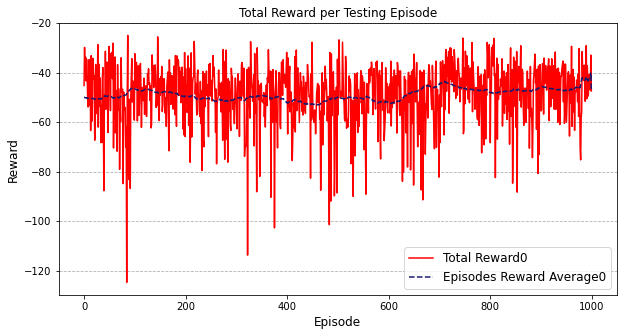

In [68]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

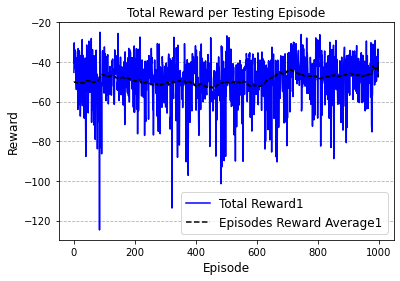

In [69]:
plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

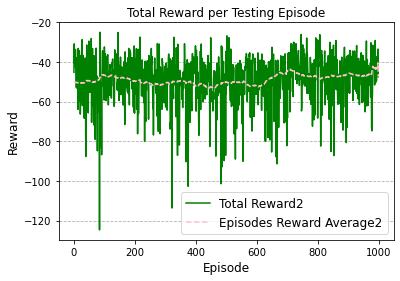

In [70]:
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

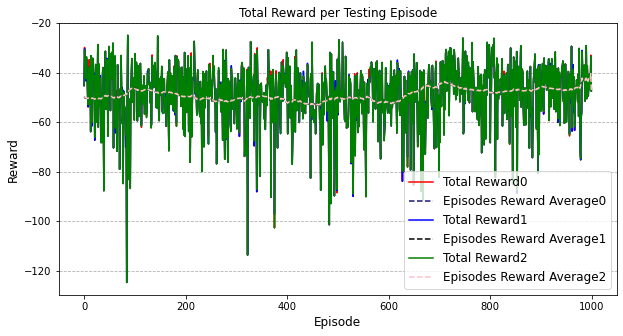

In [71]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')

plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [72]:
total_avg_reward=[]

In [73]:
for i in range(0,1000):
    k=np.mean(rewards_0[i]+rewards_1[i]+rewards_2[i])
    k=np.round(k,3)
    total_avg_reward.append(k)

In [74]:
avg_total=[]

In [75]:
for i in range(0,1000):
    k=np.mean(total_avg_reward[i:i+100])
    k=np.round(k,3)
    avg_total.append(k)

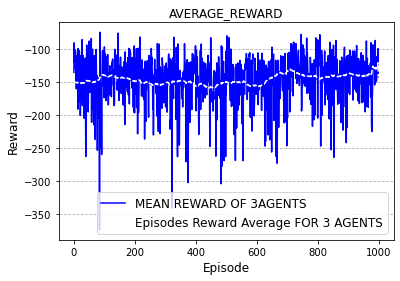

In [76]:
plt.plot(no_episodes,total_avg_reward, color = 'blue',  linestyle = '-', 
        label = 'MEAN REWARD OF 3AGENTS')
plt.plot(no_episodes, avg_total, color = 'white',  linestyle = '--', 
        label = 'Episodes Reward Average FOR 3 AGENTS')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('AVERAGE_REWARD',fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [77]:
dqn.model.save('zzzz1.h5')